In [4]:
import pandas as pd
import pickle
from scipy.stats import poisson

In [6]:
dict_table = pickle.load(open('dict_table','rb'))
df_historical_data = pd.read_csv('cleaned_fifa_worldcup_matches.csv')
df_fixture = pd.read_csv('cleaned_fifa_worldcup22_fixture.csv')

In [8]:
dict_table.keys()

dict_keys(['Group A', 'Group B', 'Group C', 'Group D', 'Group E', 'Group F', 'Group G', 'Group H'])

In [9]:
df_historical_data

,HomeTeam,AwayTeam,Year,HomeGoals,AwayGoals,TotalGoals
0,France,Mexico,1930,4,1,5
1,Uruguay,Argentina,1930,4,2,6
2,Uruguay,Yugoslavia,1930,6,1,7
3,Argentina,United States,1930,6,1,7
4,Paraguay,Belgium,1930,1,0,1
...,...,...,...,...,...,...
1039,Brazil,Costa Rica,2018,2,0,2
1040,Serbia,Switzerland,2018,1,2,3
1041,Serbia,Brazil,2018,0,2,2
1042,Germany,Mexico,2018,0,1,1


In [10]:
df_fixture

,home,score,away,year
0,Qatar,0–2,Ecuador,2022
1,Senegal,0–2,Netherlands,2022
2,Qatar,1–3,Senegal,2022
3,Netherlands,1–1,Ecuador,2022
4,Ecuador,1–2,Senegal,2022
...,...,...,...,...
59,England,Match 59,France,2022
60,Winners Match 57,Match 61,Winners Match 58,2022
61,Winners Match 59,Match 62,Winners Match 60,2022
62,Losers Match 61,Match 63,Losers Match 62,2022


### Discovering the Team Strength

In [11]:
#Splitting dataframe into df_home & df_away seperate dfs
df_home = df_historical_data[['HomeTeam', 'HomeGoals', 'AwayGoals']]

df_away = df_historical_data[['AwayTeam', 'HomeGoals', 'AwayGoals']]

In [12]:
df_home

,HomeTeam,HomeGoals,AwayGoals
0,France,4,1
1,Uruguay,4,2
2,Uruguay,6,1
3,Argentina,6,1
4,Paraguay,1,0
...,...,...,...
1039,Brazil,2,0
1040,Serbia,1,2
1041,Serbia,0,2
1042,Germany,0,1


In [13]:
df_away

,AwayTeam,HomeGoals,AwayGoals
0,Mexico,4,1
1,Argentina,4,2
2,Yugoslavia,6,1
3,United States,6,1
4,Belgium,1,0
...,...,...,...
1039,Costa Rica,2,0
1040,Switzerland,1,2
1041,Brazil,0,2
1042,Mexico,0,1


In [15]:
#Renaming the columns for the team, goals for the 2 dataframes
df_home = df_home.rename(columns= {'HomeTeam':'Team', 'HomeGoals': 'GoalsScored', 'AwayGoals': 'GoalsConceded'})
df_away = df_away.rename(columns= {'AwayTeam':'Team', 'HomeGoals': 'GoalsConceded', 'AwayGoals': 'GoalsScored'})

In [16]:
#Concat both the dfs, building the team strength  by team and calculating the mean into a new df = 'df_team_strength'
df_team_strength = pd.concat([df_home,df_away], ignore_index=True).groupby('Team').mean()

df_team_strength

,GoalsScored,GoalsConceded
Team,,
Algeria,0.812500,1.312500
Angola,0.333333,0.666667
Argentina,1.711111,1.077778
Australia,0.954545,1.909091
Austria,1.482759,1.620690
...,...,...
Uruguay,1.532258,1.274194
Wales,0.800000,0.800000
West Germany,2.112903,1.241935


### Predicting Points for each team

Poisson Distribution: Probability distribution that describes the # of events occuring in a fixed time
In this case, how many goals(events) in 90 mins of a game
Assumptions
1. The total events can be counted -> in this case goals can be counted in a whole game aka there is no such thing as .5 of a goal
2. Occurance of events are independent -> 1 goal does not affect the probability of a 2nd or 3rd goal
3. The rate of which events(goals) occur is constant -> rate of 1 goal in one match, is the same as the rate of 1 goal in another match
4. Two events cannot occur at exactly the same instant in time -> Aka there can't be two goals scored at the same time

In [18]:
#function will grab the home & away team and grab the number of 'points' they recieve
def predict_points(home, away):
    #if team is in the team strength df
    if home in df_team_strength.index and away in df_team_strength.index:
        # goals_scored * goals_conceded
        lamb_home = df_team_strength.at[home,'GoalsScored'] * df_team_strength.at[away,'GoalsConceded']
        lamb_away = df_team_strength.at[away,'GoalsScored'] * df_team_strength.at[home,'GoalsConceded']
        # basically the more goals the team can score makes the lamba of the home team higher
        prob_home, prob_away, prob_draw = 0, 0, 0
        
        #Simulations of the games using a range of 1 to 10 (as in 0 to 10 goals)
        #Grabbing the scores for both home and away teams
        for x in range(0,11): #number of goals home team
            for y in range(0, 11): #number of goals away team
                p = poisson.pmf(x, lamb_home) * poisson.pmf(y, lamb_away)
                if x == y:
                    prob_draw += p
                elif x > y:
                    prob_home += p
                else:
                    prob_away += p
        
        points_home = 3 * prob_home + prob_draw
        points_away = 3 * prob_away + prob_draw
        return (points_home, points_away)
    else:
        return (0, 0)

### Testing Function with some recent games that happened

In [20]:
### Testing Function with some recent games that happened

print(predict_points('Japan', 'Croatia'))
print(predict_points('Argentina', 'Mexico'))
print(predict_points('Brazil', 'South Korea'))

(0.9561612443159686, 1.8117950358881172)
(2.2677071970954774, 0.572825295468296)
(2.699204401277746, 0.21639185546101203)


Testing got 2 out 3 correct given that Brazil recently beat Korea 4-1

## World Cup Predictions

### Group Stages

In [21]:
#Creating different dfs into groupstages that have the first 48 games 
df_fixture_group_48 = df_fixture[:48].copy()
#This df is for the knockout rounds
df_fixture_knockout = df_fixture[48:56].copy()
#quarter finals
df_fixture_quarter = df_fixture[56:60].copy()
#Semi Finals
df_fixture_semi = df_fixture[60:62].copy()
#Gran Finale df
df_fixture_final = df_fixture[62:].copy()

In [22]:
#Simulating all the group stage matches and adding their scores to the 1st df
for group in dict_table:
    teams_in_group = dict_table[group]['Team'].values
    #every team is going to play 6 matches
    df_fixture_group_6 = df_fixture_group_48[df_fixture_group_48['home'].isin(teams_in_group)]
    for index, row in df_fixture_group_6.iterrows():
        home, away = row['home'], row['away']
        points_home, points_away = predict_points(home, away)
        #adding the points to the table, using loc to find the team according to the dict_table
        dict_table[group].loc[dict_table[group]['Team'] == home, 'Pts'] += points_home
        dict_table[group].loc[dict_table[group]['Team'] == away, 'Pts'] += points_away
    #changes to final table aka sort values by points and then organizing them by desc order
    dict_table[group] = dict_table[group].sort_values('Pts', ascending=False).reset_index()
    dict_table[group] = dict_table[group][['Team', 'Pts']]
    dict_table[group] = dict_table[group].round(0)

In [32]:
#Displaying the simulated outcome of each group stage
dict_table['Group A']

,Team,Pts
0,Netherlands,11.0
1,Senegal,8.0
2,Ecuador,6.0
3,Qatar (H),0.0


In [25]:
dict_table['Group B']

,Team,Pts
0,England,13.0
1,United States,8.0
2,Wales,6.0
3,Iran,5.0


In [26]:
dict_table['Group C']

,Team,Pts
0,Argentina,13.0
1,Poland,9.0
2,Mexico,8.0
3,Saudi Arabia,4.0


In [27]:
dict_table['Group D']

,Team,Pts
0,France,13.0
1,Australia,8.0
2,Denmark,7.0
3,Tunisia,6.0


In [28]:
dict_table['Group E']

,Team,Pts
0,Germany,11.0
1,Spain,9.0
2,Japan,9.0
3,Costa Rica,5.0


In [29]:
dict_table['Group F']

,Team,Pts
0,Croatia,11.0
1,Morocco,11.0
2,Belgium,10.0
3,Canada,0.0


In [30]:
dict_table['Group G']

,Team,Pts
0,Brazil,14.0
1,Switzerland,10.0
2,Cameroon,6.0
3,Serbia,4.0


In [31]:
dict_table['Group H']

,Team,Pts
0,Portugal,12.0
1,Uruguay,9.0
2,Ghana,7.0
3,South Korea,6.0


### Knock Out Stages

In [33]:
df_fixture_knockout

,home,score,away,year
48,Netherlands,3–1,United States,2022
49,Argentina,2–1,Australia,2022
50,France,3–1,Poland,2022
51,England,3–0,Senegal,2022
52,Japan,Match 53,Croatia,2022
53,Brazil,Match 54,South Korea,2022
54,Morocco,Match 55,Spain,2022
55,Portugal,Match 56,Switzerland,2022


In [34]:
#update ko fixture with group winners and runners up
for group in dict_table:
    #this is referring to the first place team
    group_winner = dict_table[group].loc[0, 'Team']
    #this is referring to the second place team from the group
    runners_up = dict_table[group].loc[1, 'Team']
    #renaming the names
    df_fixture_knockout.replace({f'Winners {group}':group_winner,
                                 f'Runners-up {group}':runners_up}, inplace=True)

df_fixture_knockout['winner'] = '?'
df_fixture_knockout

,home,score,away,year,winner
48,Netherlands,3–1,United States,2022,?
49,Argentina,2–1,Australia,2022,?
50,France,3–1,Poland,2022,?
51,England,3–0,Senegal,2022,?
52,Japan,Match 53,Croatia,2022,?
53,Brazil,Match 54,South Korea,2022,?
54,Morocco,Match 55,Spain,2022,?
55,Portugal,Match 56,Switzerland,2022,?


#### Keep in mind some of these knockout matches already happened prior to the start of this project

In [37]:
#Get the winner 
def get_winner(df_fixture_updated):
    for index, row in df_fixture_updated.iterrows():
        home, away = row['home'], row['away']
        points_home, points_away = predict_points(home, away)
        if points_home > points_away:
            winner = home
        else:
            winner = away
        df_fixture_updated.loc[index, 'winner'] = winner
    return df_fixture_updated

In [38]:
get_winner(df_fixture_knockout)

,home,score,away,year,winner
48,Netherlands,3–1,United States,2022,Netherlands
49,Argentina,2–1,Australia,2022,Argentina
50,France,3–1,Poland,2022,France
51,England,3–0,Senegal,2022,England
52,Japan,Match 53,Croatia,2022,Croatia
53,Brazil,Match 54,South Korea,2022,Brazil
54,Morocco,Match 55,Spain,2022,Spain
55,Portugal,Match 56,Switzerland,2022,Portugal


### Quarter Final

In [39]:
df_fixture_quarter

,home,score,away,year
56,Winners Match 53,Match 58,Winners Match 54,2022
57,Netherlands,Match 57,Argentina,2022
58,Winners Match 55,Match 60,Winners Match 56,2022
59,England,Match 59,France,2022


In [40]:
#Create the updated table function
def update_table(df_fixture_round_1, df_fixture_round_2):
    for index, row in df_fixture_round_1.iterrows():
        winner = df_fixture_round_1.loc[index, 'winner']
        match = df_fixture_round_1.loc[index, 'score']
        df_fixture_round_2.replace({f'Winners {match}':winner}, inplace=True)
    df_fixture_round_2['winner'] = '?'
    return df_fixture_round_2

In [41]:
update_table(df_fixture_knockout, df_fixture_quarter)

,home,score,away,year,winner
56,Croatia,Match 58,Brazil,2022,?
57,Netherlands,Match 57,Argentina,2022,?
58,Spain,Match 60,Portugal,2022,?
59,England,Match 59,France,2022,?


In [43]:
#Find the winners for the quarter final matches
get_winner(df_fixture_quarter)

,home,score,away,year,winner
56,Croatia,Match 58,Brazil,2022,Brazil
57,Netherlands,Match 57,Argentina,2022,Netherlands
58,Spain,Match 60,Portugal,2022,Portugal
59,England,Match 59,France,2022,England


### Semi Final

In [44]:
update_table(df_fixture_quarter, df_fixture_semi)

,home,score,away,year,winner
60,Netherlands,Match 61,Brazil,2022,?
61,England,Match 62,Portugal,2022,?


In [45]:
get_winner(df_fixture_semi)

,home,score,away,year,winner
60,Netherlands,Match 61,Brazil,2022,Brazil
61,England,Match 62,Portugal,2022,Portugal


### Final Match

In [46]:
update_table(df_fixture_semi, df_fixture_final)

,home,score,away,year,winner
62,Losers Match 61,Match 63,Losers Match 62,2022,?
63,Brazil,Match 64,Portugal,2022,?


In [47]:
get_winner(df_fixture_final)

,home,score,away,year,winner
62,Losers Match 61,Match 63,Losers Match 62,2022,Losers Match 62
63,Brazil,Match 64,Portugal,2022,Brazil


# THE 2022 WORLD CUP WINNER: BRAZIL

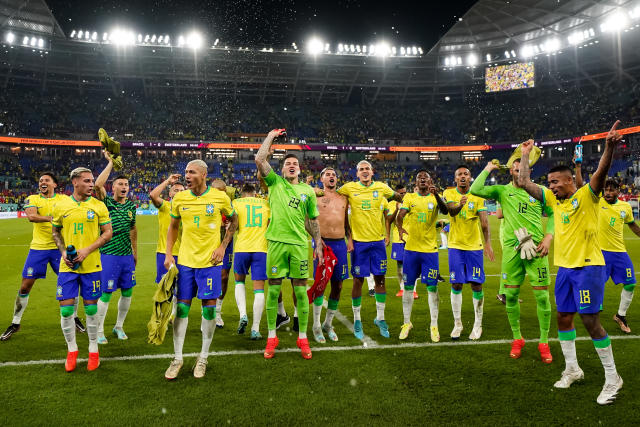